In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import random
import math
from networkx.algorithms.community.modularity_max import greedy_modularity_communities


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/COSC4086AtulKumar/Datasets/UnweightedDatasets/Facebook1'
%ls

/content/drive/MyDrive/COSC4086AtulKumar/Datasets/UnweightedDatasets/Facebook1
facebook1.csv                       Preprocessed_X_Test1.csv
facebook1.txt                       Preprocessed_X_Train1.csv
graphNetworkNegative.csv            testComm
Preprocessed_test_With_Labels.csv   trainComm
Preprocessed_train_With_Labels.csv


In [ ]:
# reading data from 'soc-Epinions1.txt'
fileName='facebook1.txt'
srcDest=[]
with open(fileName) as file:
  for lineNumber, i in enumerate(file):
    if i[0]=='#':
      continue
    else:
      srcDest.append(i.split(' '))

for i in range(len(srcDest)):
  if "\n" in srcDest[i][1]:
    srcDest[i][1]=srcDest[i][1][:len(srcDest[i][1])-1]


In [ ]:
srcDest[0:5]

[['0', '1'], ['0', '2'], ['0', '3'], ['0', '4'], ['0', '5']]

In [ ]:
len(srcDest)

88234

In [ ]:
graphNetwork = pd.DataFrame(columns=['u', 'v'])

In [ ]:
for i in range(len(srcDest)):
  edgeRead = {'u': (int)(srcDest[i][0]), 'v':(int)(srcDest[i][1])}
  graphNetwork=pd.concat([graphNetwork, pd.DataFrame(edgeRead, index=[0])], ignore_index=True)


In [ ]:
graphNetwork.to_csv('facebook1.csv', index=False)

In [ ]:
graphNetwork.head()

,u,v
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5


In [ ]:
len(graphNetwork)

88234

In [ ]:
#checking loops and removing it if found any
listOfLoops = []
countingLoops=0

for i in range(0, len(graphNetwork)):
  if graphNetwork.iloc[i,0]==graphNetwork.iloc[i,1]:
    listOfLoops.append(i)
    
for i in listOfLoops:
    graphNetwork.drop(i, inplace=True)
    countingLoops+=1
print("Number of loops that were existed in the graph: ", countingLoops)

countingLoops=0
for i in range(0, len(graphNetwork)):
  if graphNetwork.iloc[i,0]==graphNetwork.iloc[i,1]:
    countingLoops+=1
print("Number of loops that still exist in the graph: ", countingLoops)

Number of loops that were existed in the graph:  0
Number of loops that still exist in the graph:  0


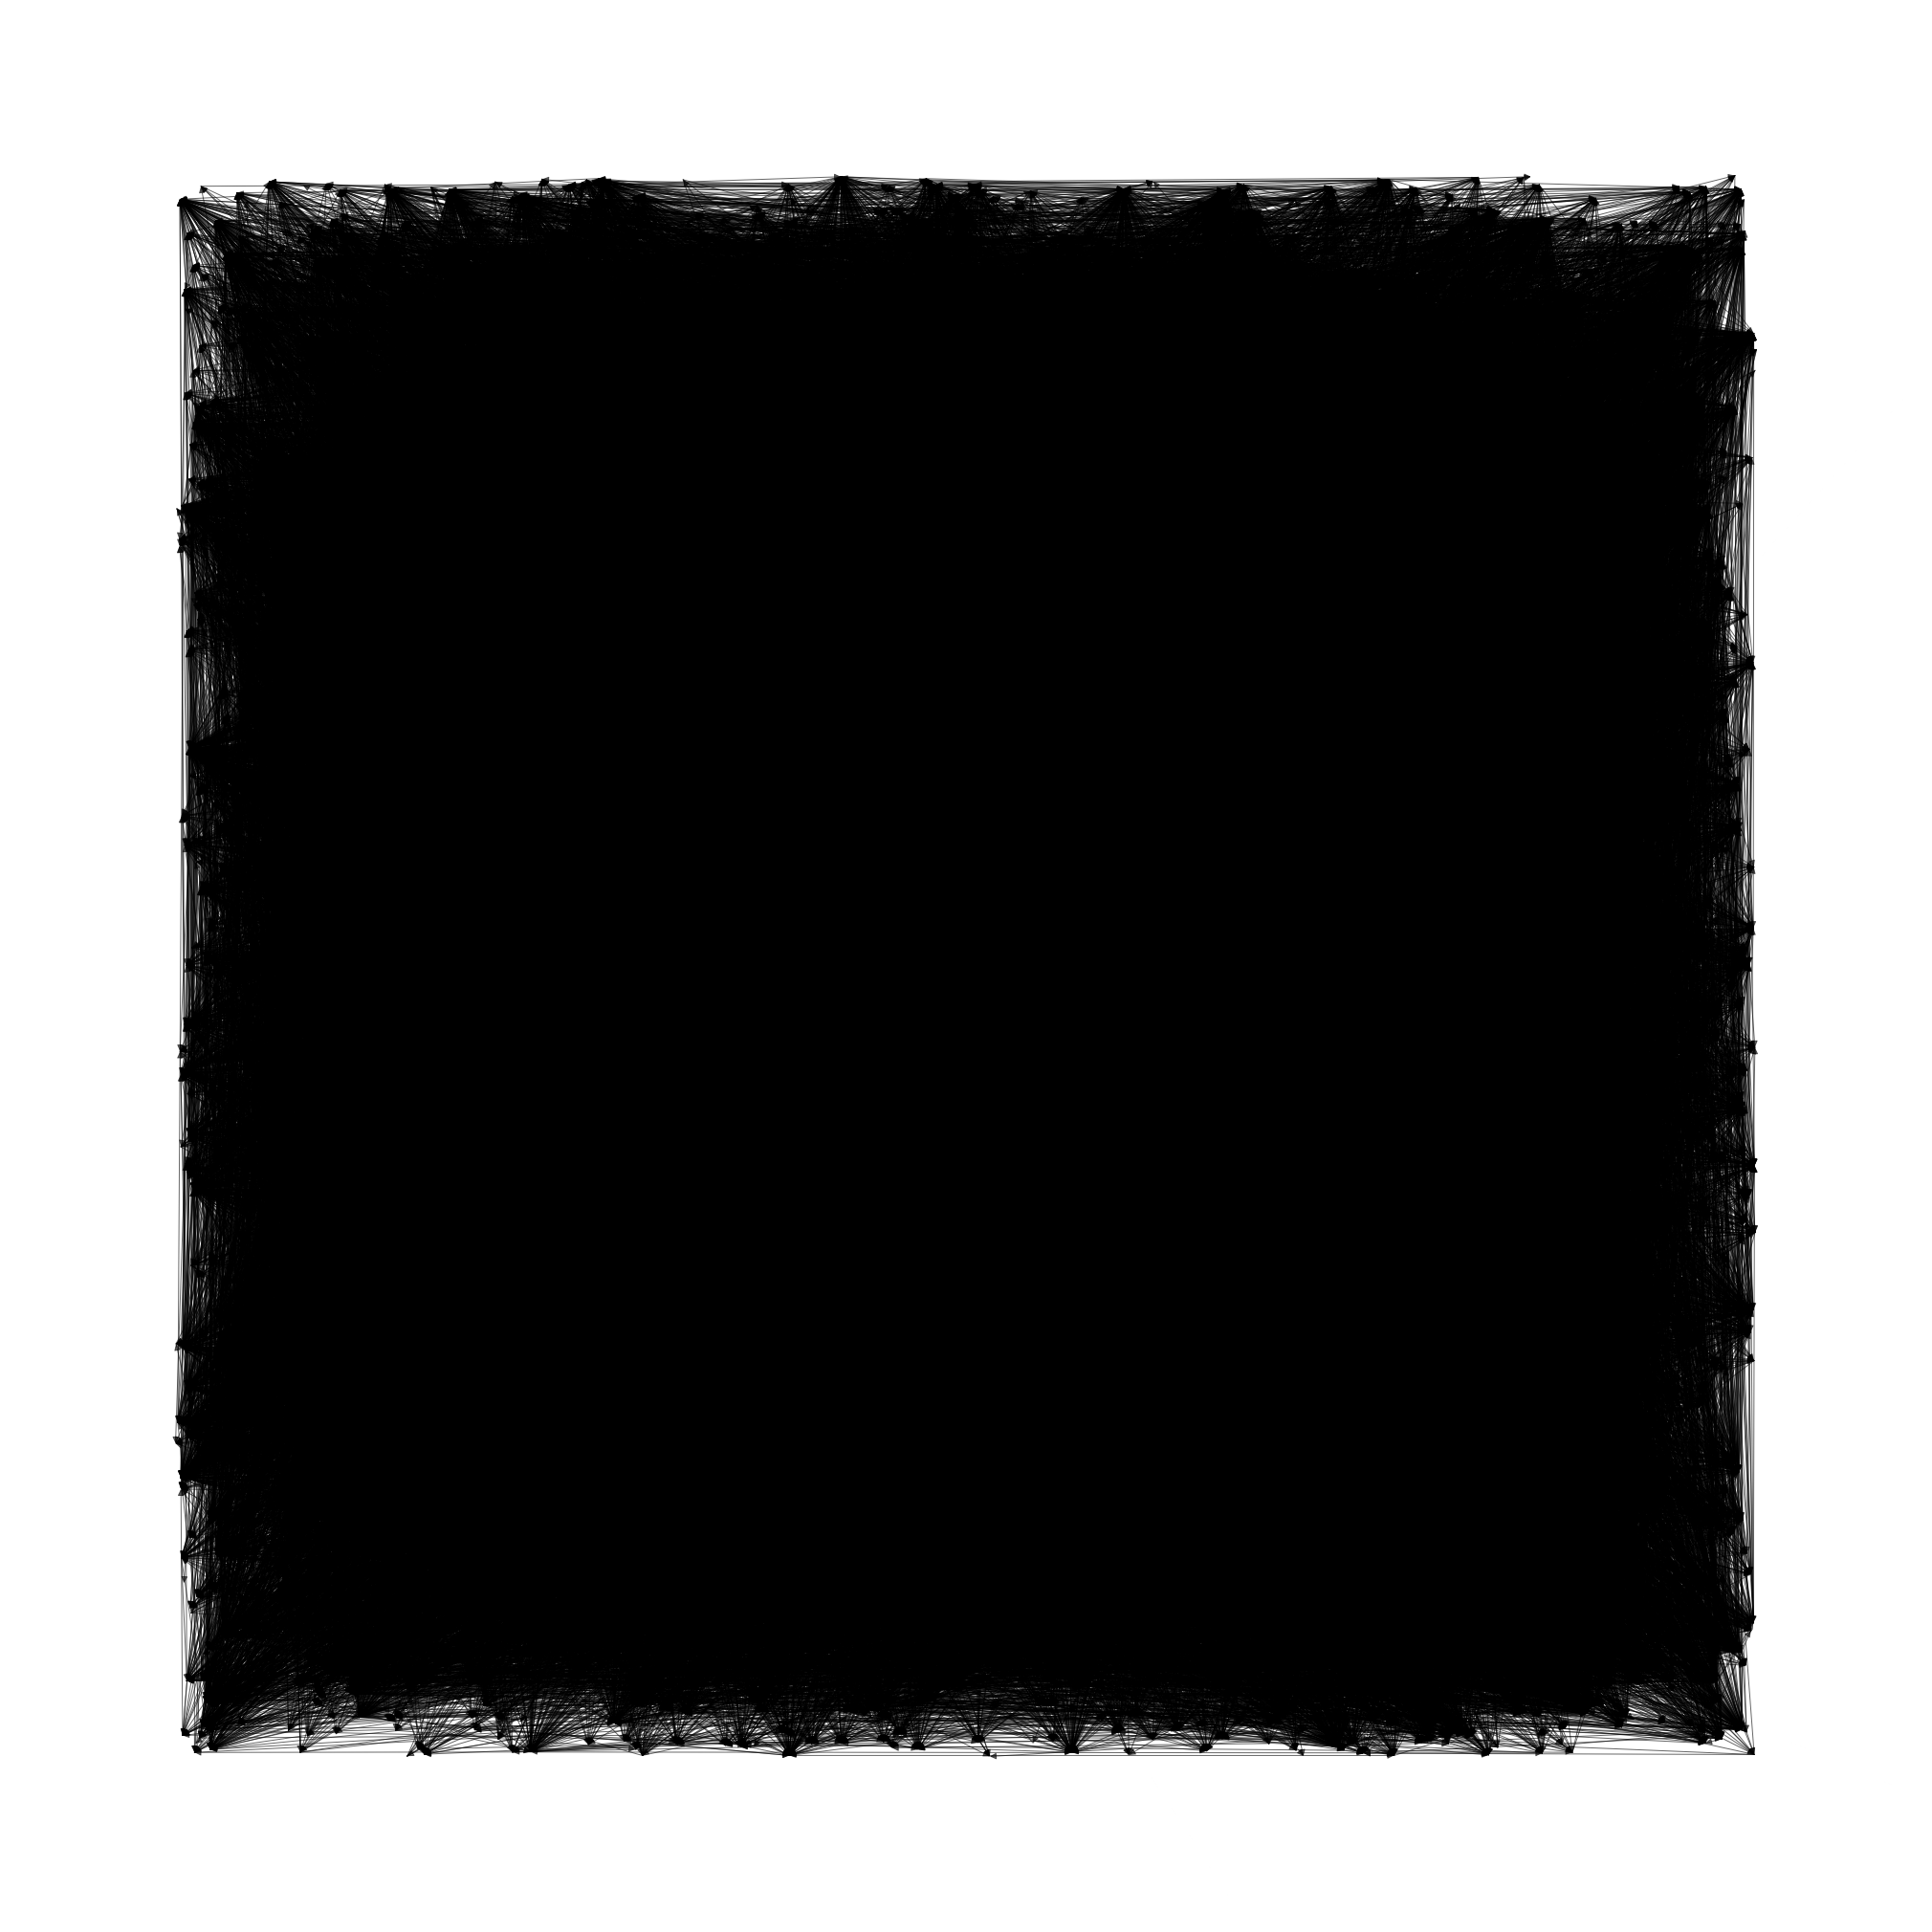

In [ ]:
graph = nx.from_pandas_edgelist(graphNetwork, 'u', 'v', create_using=nx.DiGraph())
plt.figure(figsize=(20,20))
nx.draw(graph, with_labels=False,  pos = nx.random_layout(graph, seed = 46), node_size = 0.0, alpha = 0.6, width = 0.7)
plt.show()

In [ ]:
following = graph.out_degree()
following = list(following)
maxFollowing=(following[0])[1]
node=1
for i in following:
  if maxFollowing < i[1]:
    maxFollowing = i[1]
    node=i[0]
print("Node", node, "has the maximum number of following")

Node 107 has the maximum number of following


In [ ]:
followers=graph.in_degree()
followers=list(followers)
maxFollowers=(followers[0])[1]
node=1
for i in followers:
  if maxFollowers < i[1]:
    maxFollowers = i[1]
    node=i[0]
print("Node", node, "has the maximum number of followers")

Node 1888 has the maximum number of followers


In [ ]:
# showing the graph is undirected
print("Is the graph undirected? ",following==followers)

Is the graph undirected?  False


In [ ]:
numberOfIsolatedNodes=0
for i in graph.nodes():
  if len(list(graph.predecessors(i)))==0 and len(list(graph.successors(i)))==0:
     numberOfIsolatedNodes=numberOfIsolatedNodes+1
     print(i)
print("Number of isolated nodes: ", numberOfIsolatedNodes)

Number of isolated nodes:  0


In [ ]:
print("Number of nodes in the graph: ", len(graph.nodes()))

Number of nodes in the graph:  4039


In [ ]:
graphNetworkPos=graphNetwork.copy()

In [ ]:
# present edges
graphNetworkPos['Edge_Status']=1

In [ ]:
graphNetworkPos

,u,v,Edge_Status
0,0,1,1
1,0,2,1
2,0,3,1
3,0,4,1
4,0,5,1
...,...,...,...
88229,4026,4030,1
88230,4027,4031,1
88231,4027,4032,1
88232,4027,4038,1


In [ ]:
minU = graphNetworkPos['u'].min()
maxU = graphNetworkPos['u'].max()
minV = graphNetworkPos['v'].min()
maxV = graphNetworkPos['v'].max()
print("'u' column has number from range ",minU,'to', maxU)
print("'v' column has number from range ",minV,'to', maxV)

'u' column has number from range  0 to 4031
'v' column has number from range  1 to 4038


In [ ]:
# absent edges
graphNetworkNeg = pd.DataFrame(columns=['u', 'v', 'Edge_Status'])

In [ ]:
graphNetworkNeg

,u,v,Edge_Status


In [ ]:
#generating edges that are not present in the graph (that will be used as negative instances in the dataset)
while len(graphNetworkNeg)<len(graphNetworkPos):  #len(graphNetworkPos)
  missedU = random.randint(minU, maxU)
  missedV = random.randint(minV, maxV)
  while(missedU==missedV):
    missedV = random.randint(minV, maxV)
  if missedU in graphNetworkPos['u'].values and missedV in graphNetworkPos['v'].values and nx.has_path(graph, missedU, missedV) and graphNetworkPos.isin({'u':[missedU], 'v':[missedV], 'Edge_Status':[1]}).all(axis=1).any()==False and graphNetworkNeg.isin({'u':[missedU], 'v':[missedV], 'Edge_Status':[0]}).all(axis=1).any()==False and  nx.shortest_path_length(graph, source=missedU, target=missedV)>2:
    newMissedEdge={'u':missedU, 'v':missedV, 'Edge_Status':0}
    graphNetworkNeg=pd.concat([graphNetworkNeg, pd.DataFrame(newMissedEdge, index=[0])], ignore_index=True)
    print(len(graphNetworkNeg))



Streaming output truncated to the last 5000 lines.
83235
83236
83237
83238
83239
83240
83241
83242
83243
83244
83245
83246
83247
83248
83249
83250
83251
83252
83253
83254
83255
83256
83257
83258
83259
83260
83261
83262
83263
83264
83265
83266
83267
83268
83269
83270
83271
83272
83273
83274
83275
83276
83277
83278
83279
83280
83281
83282
83283
83284
83285
83286
83287
83288
83289
83290
83291
83292
83293
83294
83295
83296
83297
83298
83299
83300
83301
83302
83303
83304
83305
83306
83307
83308
83309
83310
83311
83312
83313
83314
83315
83316
83317
83318
83319
83320
83321
83322
83323
83324
83325
83326
83327
83328
83329
83330
83331
83332
83333
83334
83335
83336
83337
83338
83339
83340
83341
83342
83343
83344
83345
83346
83347
83348
83349
83350
83351
83352
83353
83354
83355
83356
83357
83358
83359
83360
83361
83362
83363
83364
83365
83366
83367
83368
83369
83370
83371
83372
83373
83374
83375
83376
83377
83378
83379
83380
83381
83382
83383
83384
83385
83386
83387
83388
83389
83390
83391
83392
8

In [ ]:
len(graphNetworkPos)

88234

In [ ]:
len(graphNetworkNeg)

88234

In [ ]:
graphNetworkPos

,u,v,Edge_Status
0,0,1,1
1,0,2,1
2,0,3,1
3,0,4,1
4,0,5,1
...,...,...,...
88229,4026,4030,1
88230,4027,4031,1
88231,4027,4032,1
88232,4027,4038,1


In [ ]:
graphNetworkNeg

,u,v,Edge_Status
0,413,440,0
1,2018,2161,0
2,1215,3321,0
3,24,3385,0
4,493,2557,0
...,...,...,...
88229,1318,2096,0
88230,1471,3156,0
88231,982,1820,0
88232,488,1613,0


In [ ]:
graphNetworkNeg.to_csv('graphNetworkNegative.csv', index=False)

In [ ]:
graphNetworkNeg=pd.read_csv('graphNetworkNegative.csv')

In [ ]:
graphNetworkP=graphNetworkPos.drop("Edge_Status", axis=1)
graphNetworkN=graphNetworkNeg.drop("Edge_Status", axis=1)


In [ ]:
from sklearn.model_selection import train_test_split
X_train_pos, X_test_pos, y_train_pos, y_test_pos=train_test_split(graphNetworkP, graphNetworkPos['Edge_Status'], test_size=0.2, random_state=42)
X_train_neg, X_test_neg, y_train_neg, y_test_neg=train_test_split(graphNetworkN, graphNetworkNeg['Edge_Status'], test_size=0.2, random_state=42)

In [ ]:
g = nx.from_pandas_edgelist(X_train_pos, 'u', 'v', create_using=nx.DiGraph())

In [ ]:
X_train=pd.concat([X_train_pos, X_train_neg], ignore_index=True)
y_train=pd.concat([y_train_pos, y_train_neg], ignore_index=True)
X_test=pd.concat([X_test_pos, X_test_neg], ignore_index=True)
y_test=pd.concat([y_test_pos, y_test_neg], ignore_index=True)

In [ ]:
X_train

,u,v
0,3722,3753
1,1557,1761
2,1467,1867
3,2338,2617
4,2550,2600
...,...,...
141169,690,2256
141170,1061,2132
141171,1600,2840
141172,2925,3150


In [ ]:
X_test

,u,v
0,1188,1366
1,1496,1630
2,1958,2645
3,3204,3280
4,946,1181
...,...,...
35289,1986,2357
35290,517,2386
35291,1042,2031
35292,975,3020


In [ ]:
len(y_train)

141174

In [ ]:
Adj=nx.adjacency_matrix(g, nodelist=sorted(g.nodes()))
Adj=Adj.asfptype()
Adj

In [ ]:
from scipy.sparse.linalg import svds, eigs
U, s, V = svds(Adj,k = 6)

#Jaccard Coefficient 

In [ ]:
# Jaccard Cofficient for the Successors (or followees)
def jaccard_cofficient_for_followees(u,v):
  try:
    cofficient = (len(set(g.successors(u)).intersection(set(g.successors(v)))))/(len(set(g.successors(u)).union(set(g.successors(v)))))
    return cofficient
  except:
     return 0

In [ ]:
# Jaccard Cofficient for the Predecessors (or followers)
def jaccard_cofficient_for_followers(u,v):
  try:
    cofficient = (len(set(g.predecessors(u)).intersection(set(g.predecessors(v)))))/(len(set(g.predecessors(u)).union(set(g.predecessors(v)))))
    return cofficient
  except:
    return 0

#Common Neighbor

In [ ]:
# common neighbor score for the Successors (or followees)

# (math.sqrt((g.out_degree(u)*g.out_degree(v)))): For normalizing the score
def common_neighbors_for_followees(u,v):
  try:
    score = (len(set(g.successors(u)).intersection(set(g.successors(v)))))/(math.sqrt((g.out_degree(u)*g.out_degree(v))))
    return score
  except:
     return 0

In [ ]:
# common neighbor score for the Successors (or followees)

# (math.sqrt((g.in_degree(u)*g.in_degree(v)))): For normalizing the score
def common_neighbors_for_followers(u,v):
  try:
    score = (len(set(g.predecessors(u)).intersection(set(g.predecessors(v)))))/(math.sqrt((g.in_degree(u)*g.in_degree(v))))
    return score
  except:
     return 0

#Preferential Attachment Score

In [ ]:
# preferential_attachement_score for the Successors (or followees)
# (math.sqrt((g.out_degree(u)*g.out_degree(v)))): For normalizing the score
def preferential_attachement_score_for_followees(u,v):
  try:
    score = (len(set(g.successors(u))))*(len(set(g.successors(v))))/(math.sqrt((g.out_degree(u)*g.out_degree(v))))
    return score
  except:
     return 0

In [ ]:
# preferential_attachement_score for the predecessors (or followers)
# (math.sqrt((g.in_degree(u)*g.in_degree(v)))): For normalizing the score
def preferential_attachement_score_for_followers(u,v):
  try:
    score = (len(set(g.predecessors(u))))*(len(set(g.predecessors(v))))/(math.sqrt((g.in_degree(u)*g.in_degree(v))))
    return score
  except:
     return 0

#kNN weights

In [ ]:
import math

In [ ]:
def kNN_weight_indegree(node):
  try:
    return 1/(math.sqrt(1+g.in_degree(node)))
  except:
    return 0

def kNN_weight_outdegree(node):
  try:
    return 1/(math.sqrt(1+g.out_degree(node)))
  except:
    return 0

In [ ]:
def kNNW_1(u,v):
  try:
    return kNN_weight_indegree(u)+kNN_weight_indegree(v)
  except:
    return 0

def kNNW_2(u,v):
  try:
    return kNN_weight_indegree(u)+kNN_weight_outdegree(v)
  except:
    return 0

def kNNW_3(u,v):
  try:
    return kNN_weight_outdegree(u)+kNN_weight_indegree(v)
  except:
    return 0

def kNNW_4(u,v):
  try:
    return kNN_weight_outdegree(u)+kNN_weight_outdegree(v)
  except:
    return 0

def kNNW_5(u,v):
  try:
    return kNN_weight_indegree(u)*kNN_weight_indegree(v)
  except:
    return 0

def kNNW_6(u,v):
  try:
    return kNN_weight_indegree(u)*kNN_weight_outdegree(v)
  except:
    return 0

def kNNW_7(u,v):
  try:
    return kNN_weight_outdegree(u)*kNN_weight_indegree(v)
  except:
    return 0

def kNNW_8(u,v):
  try:
    return kNN_weight_outdegree(u)*kNN_weight_outdegree(v)
  except:
    return 0

#Sorensen Index

In [ ]:
def sorensen_index_for_followees(u,v):
  try:
    score = (len(set(g.successors(u)).intersection(set(g.successors(v)))))/(g.out_degree(u)+g.out_degree(v))
    return score
  except:
     return 0

In [ ]:
def sorensen_index_for_followers(u,v):
  try:
    score = (len(set(g.predecessors(u)).intersection(set(g.predecessors(v)))))/(g.in_degree(u)+g.in_degree(v))
    return score
  except:
     return 0

#Salton Cosine Similarity

In [ ]:
def salton_cosine_for_followees(u,v):
  try:
    score = (len(set(g.successors(u)).intersection(set(g.successors(v)))))/math.sqrt((g.out_degree(u)*g.out_degree(v)))
    return score
  except:
     return 0

In [ ]:
def salton_cosine_for_followers(u,v):
  try:
    score = (len(set(g.predecessors(u)).intersection(set(g.predecessors(v)))))/math.sqrt((g.in_degree(u)*g.in_degree(v)))
    return score
  except:
     return 0

#Adamic/Adar Index

In [ ]:
def adamic_adar_index_for_followees(u,v):
  totalSum=0
  try:
    common_successors=list(set(g.successors(u)).intersection(set(g.successors(v))))
    for i in range(0,len(common_successors)):
      totalSum=totalSum+ g.out_degree(common_successors[i])
    if(totalSum!=0):  
      if(1/np.log10(totalSum)==math.inf):
        return 0
      return 1/np.log10(totalSum)
    else:
      return 0
  except:
    return 0

In [ ]:
def adamic_adar_index_for_followers(u,v):
  totalSum=0
  try:
    common_predecessors=list(set(g.predecessors(u)).intersection(set(g.predecessors(v))))
    for i in range(0,len(common_predecessors)):
      totalSum=totalSum+ g.in_degree(common_predecessors[i])
    if(totalSum!=0):  
      if(1/np.log10(totalSum)==math.inf):
        return 0  
      return 1/np.log10(totalSum)
    else:
      return 0
  except:
    return 0

#PageRank

In [ ]:
pageRank = nx.pagerank(g, alpha=0.9, tol=1e-07, max_iter=250)

In [ ]:
len(pageRank)

4017

In [ ]:
pageRankMean=float(sum(pageRank.values())) / len(pageRank)
pageRankMean

0.00024894199651481096

#Katz Centrality Score

In [ ]:
katz_centrality_score = nx.katz.katz_centrality(g, alpha=0.01, beta = 0.01)

In [ ]:
katz_centrality_mean=float(sum(katz_centrality_score.values())) / len(katz_centrality_score)
katz_centrality_mean

0.015086772290036677

#HITS Score

In [ ]:
hitsScore = nx.hits(g, max_iter=50, tol=1e-08, nstart=None, normalized=True)


#Follow Back Edge


In [ ]:
def follows_back(u,v):
  if(g.has_edge(v,u)):
    return 1
  else:
    return 0

#Detecting Community

In [ ]:
from networkx.algorithms.community.modularity_max import greedy_modularity_communities


In [ ]:

def is_same_community(u,v, community_list):
    status=False

    for i in range(len(community_list)):
      if u in community_list[i] and v in community_list[i]:
        status=False
        return 1
        break
      if u in community_list[i] and v not in community_list[i]:
        status=False
        return 0
        break
      if u not in community_list[i] and v in community_list[i]:
        status=False
        return 0
        break
      status=True
    
    if status==True:
      return 0


In [ ]:
X_train.head()

,u,v
0,3722,3753
1,1557,1761
2,1467,1867
3,2338,2617
4,2550,2600


In [ ]:
X_test.head()

,u,v
0,1188,1366
1,1496,1630
2,1958,2645
3,3204,3280
4,946,1181


##Appending all the similarity indices into the dataframe

In [ ]:
#  adding jaccard cofficient to the dataframe

X_train['Jaccard_OUT']=X_train.apply(lambda row: jaccard_cofficient_for_followees(row['u'], row['v']), axis=1)
X_train['Jaccard_IN']=X_train.apply(lambda row: jaccard_cofficient_for_followers(row['u'], row['v']), axis=1)
X_test['Jaccard_OUT']=X_test.apply(lambda row: jaccard_cofficient_for_followees(row['u'], row['v']), axis=1)
X_test['Jaccard_IN']=X_test.apply(lambda row: jaccard_cofficient_for_followers(row['u'], row['v']), axis=1)


In [ ]:
#  adding Common Neighbor cofficient to the dataframe

X_train['CN_OUT']=X_train.apply(lambda row: common_neighbors_for_followees(row['u'], row['v']), axis=1)
X_train['CN_IN']=X_train.apply(lambda row: common_neighbors_for_followers(row['u'], row['v']), axis=1)
X_test['CN_OUT']=X_test.apply(lambda row: common_neighbors_for_followees(row['u'], row['v']), axis=1)
X_test['CN_IN']=X_test.apply(lambda row: common_neighbors_for_followers(row['u'], row['v']), axis=1)


In [ ]:
#  adding Preferential Attachment Score to the dataframe

X_train['PAS_OUT']=X_train.apply(lambda row: preferential_attachement_score_for_followees(row['u'], row['v']), axis=1)
X_train['PAS_IN']=X_train.apply(lambda row: preferential_attachement_score_for_followers(row['u'], row['v']), axis=1)
X_test['PAS_OUT']=X_test.apply(lambda row: preferential_attachement_score_for_followees(row['u'], row['v']), axis=1)
X_test['PAS_IN']=X_test.apply(lambda row: preferential_attachement_score_for_followers(row['u'], row['v']), axis=1)


In [ ]:
#  adding kNN weights to the dataframe

X_train['kNNW_1']=X_train.apply(lambda row: kNNW_1(row['u'], row['v']), axis=1)
X_train['kNNW_2']=X_train.apply(lambda row: kNNW_2(row['u'], row['v']), axis=1)
X_train['kNNW_3']=X_train.apply(lambda row: kNNW_3(row['u'], row['v']), axis=1)
X_train['kNNW_4']=X_train.apply(lambda row: kNNW_4(row['u'], row['v']), axis=1)
X_train['kNNW_5']=X_train.apply(lambda row: kNNW_5(row['u'], row['v']), axis=1)
X_train['kNNW_6']=X_train.apply(lambda row: kNNW_6(row['u'], row['v']), axis=1)
X_train['kNNW_7']=X_train.apply(lambda row: kNNW_7(row['u'], row['v']), axis=1)
X_train['kNNW_8']=X_train.apply(lambda row: kNNW_8(row['u'], row['v']), axis=1)

X_test['kNNW_1']=X_test.apply(lambda row: kNNW_1(row['u'], row['v']), axis=1)
X_test['kNNW_2']=X_test.apply(lambda row: kNNW_2(row['u'], row['v']), axis=1)
X_test['kNNW_3']=X_test.apply(lambda row: kNNW_3(row['u'], row['v']), axis=1)
X_test['kNNW_4']=X_test.apply(lambda row: kNNW_4(row['u'], row['v']), axis=1)
X_test['kNNW_5']=X_test.apply(lambda row: kNNW_5(row['u'], row['v']), axis=1)
X_test['kNNW_6']=X_test.apply(lambda row: kNNW_6(row['u'], row['v']), axis=1)
X_test['kNNW_7']=X_test.apply(lambda row: kNNW_7(row['u'], row['v']), axis=1)
X_test['kNNW_8']=X_test.apply(lambda row: kNNW_8(row['u'], row['v']), axis=1)

In [ ]:
#  adding Sorensen Index to the dataframe

X_train['Sorenson_OUT']=X_train.apply(lambda row: sorensen_index_for_followees(row['u'], row['v']), axis=1)
X_train['Sorenson_IN']=X_train.apply(lambda row: sorensen_index_for_followers(row['u'], row['v']), axis=1)
X_test['Sorenson_OUT']=X_test.apply(lambda row: sorensen_index_for_followees(row['u'], row['v']), axis=1)
X_test['Sorenson_IN']=X_test.apply(lambda row: sorensen_index_for_followers(row['u'], row['v']), axis=1)


In [ ]:
#  adding Salton Cosine Similarity Cofficient to the dataframe

X_train['SCS_OUT']=X_train.apply(lambda row: salton_cosine_for_followees(row['u'], row['v']), axis=1)
X_train['SCS_IN']=X_train.apply(lambda row: salton_cosine_for_followers(row['u'], row['v']), axis=1)
X_test['SCS_OUT']=X_test.apply(lambda row: salton_cosine_for_followees(row['u'], row['v']), axis=1)
X_test['SCS_IN']=X_test.apply(lambda row: salton_cosine_for_followers(row['u'], row['v']), axis=1)


In [ ]:
#  adding Adamic/Adar Index to the dataframe

X_train['AAI_OUT']=X_train.apply(lambda row: adamic_adar_index_for_followees(row['u'], row['v']), axis=1)
X_train['AAI_IN']=X_train.apply(lambda row: adamic_adar_index_for_followers(row['u'], row['v']), axis=1)
X_test['AAI_OUT']=X_test.apply(lambda row: adamic_adar_index_for_followees(row['u'], row['v']), axis=1)
X_test['AAI_IN']=X_test.apply(lambda row: adamic_adar_index_for_followers(row['u'], row['v']), axis=1)


<ipython-input-71-e4130e64370f>:8: RuntimeWarning: divide by zero encountered in double_scalars
  if(1/np.log10(totalSum)==math.inf):
<ipython-input-72-f8425d3199ca>:8: RuntimeWarning: divide by zero encountered in double_scalars
  if(1/np.log10(totalSum)==math.inf):
<ipython-input-71-e4130e64370f>:8: RuntimeWarning: divide by zero encountered in double_scalars
  if(1/np.log10(totalSum)==math.inf):
<ipython-input-72-f8425d3199ca>:8: RuntimeWarning: divide by zero encountered in double_scalars
  if(1/np.log10(totalSum)==math.inf):


In [ ]:
#  checking whether the nodes has bi-direction link or not

X_train['FollowBack']=X_train.apply(lambda row: follows_back(row['u'], row['v']), axis=1)
X_test['FollowBack']=X_test.apply(lambda row: follows_back(row['u'], row['v']), axis=1)

In [ ]:
# checking whether the nodes belong to same community or not
community_list = list(greedy_modularity_communities(g))
X_train['Same_Community']=X_train.apply(lambda row: is_same_community(row['u'], row['v'],community_list), axis=1)
X_test['Same_Community']=X_test.apply(lambda row: is_same_community(row['u'], row['v'],community_list), axis=1)

In [ ]:
X_train.to_csv('trainComm', index=False)
X_test.to_csv('testComm', index=False)

In [ ]:
# adding PageRank of each node forming a edge in the dataframe

X_train['PR_U']=X_train.u.apply(lambda node: pageRank.get(node, pageRankMean))
X_train['PR_V']=X_train.v.apply(lambda node: pageRank.get(node, pageRankMean))
X_test['PR_U']=X_test.u.apply(lambda node: pageRank.get(node, pageRankMean))
X_test['PR_V']=X_test.v.apply(lambda node: pageRank.get(node, pageRankMean))


In [ ]:
# adding Katz centrality score of each node forming a edge in the dataframe

X_train['Katz_U']=X_train.u.apply(lambda node: katz_centrality_score.get(node, katz_centrality_mean))
X_train['Katz_V']=X_train.v.apply(lambda node: katz_centrality_score.get(node, katz_centrality_mean))
X_test['Katz_U']=X_test.u.apply(lambda node: katz_centrality_score.get(node, katz_centrality_mean))
X_test['Katz_V']=X_test.v.apply(lambda node: katz_centrality_score.get(node, katz_centrality_mean))

In [ ]:
# adding hits score of each node forming a edge in the dataframe
# This computes two score: Hubs Score and Authority Score

X_train['HS_U']=X_train.u.apply(lambda node: hitsScore[0].get(node,0))
X_train['HS_V']=X_train.v.apply(lambda node: hitsScore[0].get(node,0))
X_train['AS_U']=X_train.u.apply(lambda node: hitsScore[1].get(node,0))
X_train['AS_V']=X_train.v.apply(lambda node: hitsScore[1].get(node,0))

X_test['HS_U']=X_test.u.apply(lambda node: hitsScore[0].get(node,0))
X_test['HS_V']=X_test.v.apply(lambda node: hitsScore[0].get(node,0))
X_test['AS_U']=X_test.u.apply(lambda node: hitsScore[1].get(node,0))
X_test['AS_V']=X_test.v.apply(lambda node: hitsScore[1].get(node,0))

In [ ]:
X_train

,u,v,Jaccard_OUT,Jaccard_IN,CN_OUT,CN_IN,PAS_OUT,PAS_IN,kNNW_1,kNNW_2,...,FollowBack,Same_Community,PR_U,PR_V,Katz_U,Katz_V,HS_U,HS_V,AS_U,AS_V
0,3722,3753,0.200000,0.428571,0.341882,0.601338,8.774964,14.966630,0.500735,0.596089,...,0,1,0.000163,0.000195,0.014345,0.014096,4.040733e-14,2.744670e-14,5.000233e-13,3.131962e-13
1,1557,1761,0.163934,0.159664,0.308607,0.280384,32.403703,67.764297,0.242217,0.345654,...,0,1,0.000206,0.000661,0.021409,0.028473,1.988616e-07,1.041026e-07,1.524240e-07,2.378138e-07
2,1467,1867,0.018868,0.140625,0.070711,0.270470,14.142136,66.550733,0.248814,0.597969,...,0,1,0.000152,0.001515,0.019155,0.033626,3.379629e-07,5.274026e-09,1.365909e-07,2.417106e-07
3,2338,2617,0.029412,0.226087,0.102062,0.375748,9.797959,69.195376,0.239772,0.631306,...,0,1,0.000202,0.001887,0.021790,0.028161,3.516859e-04,1.502937e-05,4.919166e-04,5.087535e-04
4,2550,2600,0.344828,0.482143,0.534522,0.657906,18.708287,123.117830,0.180007,0.354873,...,0,1,0.000356,0.000828,0.035353,0.045404,2.195329e-03,1.189973e-03,6.560026e-03,7.768034e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141169,690,2256,0.000000,0.000000,0.000000,0.000000,3.741657,2.000000,1.154320,1.284457,...,0,0,0.000075,0.000085,0.012378,0.012813,1.352488e-17,1.716742e-06,3.079192e-17,1.249320e-04
141170,1061,2132,0.000000,0.000000,0.000000,0.000000,20.149442,6.480741,0.790551,0.707539,...,0,0,0.000085,0.000111,0.012503,0.015249,1.430806e-09,3.778135e-04,1.725932e-08,2.154296e-04
141171,1600,2840,0.000000,0.000000,0.000000,0.000000,27.748874,15.231546,0.577403,0.338703,...,0,0,0.000208,0.000092,0.021986,0.012769,1.519589e-07,7.197746e-12,1.601689e-07,2.758179e-12
141172,2925,3150,0.000000,0.000000,0.000000,0.000000,32.939338,35.312887,0.333330,0.359351,...,0,0,0.000147,0.000249,0.016298,0.018283,3.551379e-11,5.459354e-11,6.668726e-12,3.641625e-11


In [ ]:
# without SVD, PropFlow, edge centrality
X_train.to_csv('Preprocessed_X_Train1.csv', index=False)
X_test.to_csv('Preprocessed_X_Test1.csv', index=False)

In [ ]:
# Adding SVD features in dataframe
sadj_col = sorted(g.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}
del sadj_col

In [ ]:
##creating two df for U valuesfor train and test data with two columns source and destination 
#and each column will have a list of 6 svd features
train_df_svd_u = pd.DataFrame()
test_df_svd_u = pd.DataFrame()
def svd_s(x):
    try:
        z = sadj_dict[x]
        return U[z]
    except:
        return [0,0,0,0,0,0]
train_df_svd_u['features_s'] = X_train.u.apply(lambda x: svd_s(x))
train_df_svd_u['features_d'] = X_train.v.apply(lambda x: svd_s(x))
test_df_svd_u['features_s'] = X_test.u.apply(lambda x: svd_s(x))
test_df_svd_u['features_d'] = X_test.v.apply(lambda x: svd_s(x))

In [ ]:
##creating two df for V valuesfor train and test data with two columns source and destination 
#and each column will have a list of 6 svd features
train_df_svd_v = pd.DataFrame()
test_df_svd_v = pd.DataFrame()
def svd_v(x):
    try:
        z = sadj_dict[x]
        return V.T[z]
    except:
        return [0,0,0,0,0,0]
    
train_df_svd_v['features_s'] = X_train.u.apply(lambda x: svd_v(x))
train_df_svd_v['features_d'] = X_train.v.apply(lambda x: svd_v(x))
test_df_svd_v['features_s'] = X_test.u.apply(lambda x: svd_v(x))
test_df_svd_v['features_d'] = X_test.v.apply(lambda x: svd_v(x))

In [ ]:
train_df_svd_u.index = X_train.index
train_df_svd_v.index = X_train.index
test_df_svd_u.index = X_test.index
test_df_svd_v.index = X_test.index

In [ ]:

X_train[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
                            pd.DataFrame(train_df_svd_u.features_s.values.tolist(), index= X_train.index)
X_test[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
                            pd.DataFrame(test_df_svd_u.features_s.values.tolist(), index= X_test.index)
X_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
                            pd.DataFrame(train_df_svd_u.features_d.values.tolist(), index= X_train.index)
X_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
                            pd.DataFrame(test_df_svd_u.features_d.values.tolist(), index= X_test.index)

In [ ]:
del train_df_svd_u
del test_df_svd_u 

In [ ]:

X_train[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
                            pd.DataFrame(train_df_svd_v.features_s.values.tolist(), index= X_train.index)
X_test[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
                            pd.DataFrame(test_df_svd_v.features_s.values.tolist(), index= X_test.index)
X_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4','svd_v_d_5', 'svd_v_d_6']] = \
                            pd.DataFrame(train_df_svd_v.features_d.values.tolist(), index= X_train.index)
X_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4','svd_v_d_5', 'svd_v_d_6']] = \
                            pd.DataFrame(test_df_svd_v.features_d.values.tolist(), index= X_test.index)

In [ ]:
del train_df_svd_v
del test_df_svd_v
# del U
# del V
del sadj_dict

In [ ]:
X_train.columns

Index(['u', 'v', 'Jaccard_OUT', 'Jaccard_IN', 'CN_OUT', 'CN_IN', 'PAS_OUT',
       'PAS_IN', 'kNNW_1', 'kNNW_2', 'kNNW_3', 'kNNW_4', 'kNNW_5', 'kNNW_6',
       'kNNW_7', 'kNNW_8', 'Sorenson_OUT', 'Sorenson_IN', 'SCS_OUT', 'SCS_IN',
       'AAI_OUT', 'AAI_IN', 'FollowBack', 'Same_Community', 'PR_U', 'PR_V',
       'Katz_U', 'Katz_V', 'HS_U', 'HS_V', 'AS_U', 'AS_V', 'svd_u_s_1',
       'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6',
       'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5',
       'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4',
       'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3',
       'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [ ]:
len(X_train.columns)

56

In [ ]:
X_train['LABEL'] = y_train
X_test['LABEL'] = y_test

In [ ]:
# X_train.to_csv('Preprocessed_train_With_Labels.csv', index=False)
# X_test.to_csv('Preprocessed_test_With_Labels.csv', index=False)

In [ ]:
X_train=pd.read_csv('Preprocessed_train_With_Labels.csv')
X_test=pd.read_csv('Preprocessed_test_With_Labels.csv')

In [ ]:
y_train = X_train.LABEL 
y_test = X_test.LABEL

In [ ]:
X_train.drop(['LABEL'],axis=1,inplace=True)
X_test.drop(['LABEL'],axis=1,inplace=True)

In [ ]:
X_train.drop(['u', 'v'],axis=1,inplace=True)
X_test.drop(['u', 'v'],axis=1,inplace=True)

In [ ]:
X_train

,Jaccard_OUT,Jaccard_IN,CN_OUT,CN_IN,PAS_OUT,PAS_IN,kNNW_1,kNNW_2,kNNW_3,kNNW_4,...,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
0,0.200000,0.428571,0.341882,0.601338,8.774964,14.966630,0.500735,0.596089,0.546874,0.642229,...,0,0,0,0,0,0,0,0,0,0
1,0.163934,0.159664,0.308607,0.280384,32.403703,67.764297,0.242217,0.345654,0.249792,0.353229,...,0,0,0,0,0,0,0,0,0,0
2,0.018868,0.140625,0.070711,0.270470,14.142136,66.550733,0.248814,0.597969,0.238086,0.587242,...,0,0,0,0,0,0,0,0,0,0
3,0.029412,0.226087,0.102062,0.375748,9.797959,69.195376,0.239772,0.631306,0.282543,0.674078,...,0,0,0,0,0,0,0,0,0,0
4,0.344828,0.482143,0.534522,0.657906,18.708287,123.117830,0.180007,0.354873,0.279449,0.454315,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141169,0.000000,0.000000,0.000000,0.000000,3.741657,2.000000,1.154320,1.284457,0.800767,0.930904,...,0,0,0,0,0,0,0,0,0,0
141170,0.000000,0.000000,0.000000,0.000000,20.149442,6.480741,0.790551,0.707539,0.566754,0.483742,...,0,0,0,0,0,0,0,0,0,0
141171,0.000000,0.000000,0.000000,0.000000,27.748874,15.231546,0.577403,0.338703,0.613880,0.375181,...,0,0,0,0,0,0,0,0,0,0
141172,0.000000,0.000000,0.000000,0.000000,32.939338,35.312887,0.333330,0.359351,0.317422,0.343443,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_test

,Jaccard_OUT,Jaccard_IN,CN_OUT,CN_IN,PAS_OUT,PAS_IN,kNNW_1,kNNW_2,kNNW_3,kNNW_4,...,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
0,0.114286,0.096774,0.208514,0.231455,19.183326,12.961481,0.563660,0.582089,0.428231,0.446660,...,0,0,0,0,0,0,0,0,0,0
1,0.142857,0.259259,0.258199,0.426996,11.618950,32.787193,0.346872,0.512344,0.400756,0.566228,...,0,0,0,0,0,0,0,0,0,0
2,0.068966,0.081081,0.175412,0.226779,11.401754,13.228757,0.574915,0.816497,0.359117,0.600698,...,0,0,0,0,0,0,0,0,0,0
3,0.269231,0.121951,0.434122,0.247537,16.124515,40.398020,0.320386,0.418218,0.387647,0.485479,...,0,0,0,0,0,0,0,0,0,0
4,0.323741,0.142857,0.515406,0.258199,87.309793,7.745967,0.679476,0.502964,0.392047,0.215536,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35289,0.000000,0.000000,0.000000,0.000000,21.540659,6.480741,0.731518,0.825178,0.446003,0.539664,...,0,0,0,0,0,0,0,0,0,0
35290,0.000000,0.000000,0.000000,0.000000,41.424630,58.378078,0.260708,0.291928,0.275965,0.307185,...,0,0,0,0,0,0,0,0,0,0
35291,0.000000,0.000000,0.000000,0.000000,18.973666,3.741657,0.930904,0.741749,0.655065,0.465910,...,0,0,0,0,0,0,0,0,0,0
35292,0.000000,0.000000,0.000000,0.000000,20.976177,7.745967,0.697214,0.735889,0.406174,0.444849,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
y_train

0         1
1         1
2         1
3         1
4         1
         ..
141169    0
141170    0
141171    0
141172    0
141173    0
Name: LABEL, Length: 141174, dtype: int64

In [ ]:
y_test

0        1
1        1
2        1
3        1
4        1
        ..
35289    0
35290    0
35291    0
35292    0
35293    0
Name: LABEL, Length: 35294, dtype: int64

#Implementing ML Models

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [ ]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier


In [ ]:
y_train=y_train.astype('int')
y_test=y_test.astype('int')

In [ ]:
#XGB BOOST 
from xgboost import XGBClassifier


classifier = XGBClassifier(max_depth= 3, learning_rate= .15, n_estimators= 300, nthread=-1, silent= True, subsample= 0.9)
classifier.fit(X_train, y_train)
accuracies = cross_val_score(classifier, X_train,  y_train, cv = 3)
print("Accuracy:{:.2f} % on training data".format(accuracies.mean()*100.0))
y_train_pred = classifier.predict(X_train)
precision = precision_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
f1=f1_score(y_train, y_train_pred)
print("Precision on training data", precision)
print("Recall on training data", recall)
print("F1 score on training data", f1)

y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Accuracy on test data", accuracy_score(y_test, y_pred))
print("Precision on test data",  precision_score(y_test, y_pred))
print("Recall on test data", recall_score(y_test, y_pred))
print("F1 score on test data",  f1_score(y_test, y_pred))


[02:33:30] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[02:35:43] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[02:36:40] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[02:37:37] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

Accuracy:97.50 % on training data
Precision on training data 0.9825200291332847
Recall on training data 0.9746695567172425
F1 score on training data 0.9785790484318326
[[17281   366]
 [  562 17085]]
Accuracy on test data 0.97370657902193
Precision on test data 0.9790269898573147
Recall on test data 0.9681532271774239
F1 score on test data 0.9735597469941308


In [ ]:
#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier

# x = data
# y = dft15['LABELBIN']

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)  ###this needs to be changed

classifier = RandomForestClassifier(n_estimators=100, max_depth= 50, random_state=30)
classifier.fit(X_train, y_train)

accuracies = cross_val_score(classifier, X_train,  y_train, cv = 3)
print("Accuracy:{:.2f} % on training data".format(accuracies.mean()*100.0))
y_train_pred = classifier.predict(X_train)
precision = precision_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
f1=f1_score(y_train, y_train_pred)
print("Precision on training data", precision)
print("Recall on training data", recall)
print("F1 score on training data", f1)

y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Accuracy on test data", accuracy_score(y_test, y_pred))
print("Precision on test data",  precision_score(y_test, y_pred))
print("Recall on test data", recall_score(y_test, y_pred))
print("F1 score on test data",  f1_score(y_test, y_pred))

# y_pred = classifier.predict(x_test)
# cm = confusion_matrix(y_test, y_pred)
# print(cm)
# accuracy_score(y_test, y_pred)

# accuracies = cross_val_score(classifier, x_train,  y_train, cv = 10)
# print("Accuracy:{:.2f} %".format(accuracies.mean()*100.0))

Accuracy:97.21 % on training data
Precision on training data 0.9999574968476829
Recall on training data 0.9999008315978863
F1 score on training data 0.9999291634199902
[[17243   404]
 [  541 17106]]
Accuracy on test data 0.9732249107497025
Precision on test data 0.9769274700171331
Recall on test data 0.9693432311441038
F1 score on test data 0.9731205734277669


In [ ]:
#DECISION TREE
from sklearn.tree import DecisionTreeClassifier

# x = data
# y = dft15['LABELBIN']

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)  ###this needs to be changed

classifier = DecisionTreeClassifier(criterion='entropy', max_depth=150)
classifier.fit(X_train, y_train)
accuracies = cross_val_score(classifier, X_train,  y_train, cv = 3)
print("Accuracy:{:.2f} % on training data".format(accuracies.mean()*100.0))
y_train_pred = classifier.predict(X_train)
precision = precision_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
f1=f1_score(y_train, y_train_pred)
print("Precision on training data", precision)
print("Recall on training data", recall)
print("F1 score on training data", f1)

y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Accuracy on test data", accuracy_score(y_test, y_pred))
print("Precision on test data",  precision_score(y_test, y_pred))
print("Recall on test data", recall_score(y_test, y_pred))
print("F1 score on test data",  f1_score(y_test, y_pred))



# y_pred = classifier.predict(x_test)
# cm = confusion_matrix(y_test, y_pred)
# print(cm)
# accuracy_score(y_test, y_pred)

# accuracies = cross_val_score(classifier, x_train,  y_train, cv = 10)
# print("Accuracy:{:.2f} %".format(accuracies.mean()*100.0))

Accuracy:96.07 % on training data
Precision on training data 1.0
Recall on training data 0.9999008315978863
F1 score on training data 0.9999504133402283
[[16924   723]
 [  710 16937]]
Accuracy on test data 0.9593981979939933
Precision on test data 0.9590600226500566
Recall on test data 0.9597665325551085
F1 score on test data 0.9594131475344833


In [ ]:
#EXTRA TREE
from sklearn.ensemble import ExtraTreesClassifier

# x = data
# y = dft15['LABELBIN']

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)  ###this needs to be changed

classifier = ExtraTreesClassifier(n_estimators=100, max_depth=150,random_state=30)
classifier.fit(X_train, y_train)
accuracies = cross_val_score(classifier, X_train,  y_train, cv = 3)
print("Accuracy:{:.2f} % on training data".format(accuracies.mean()*100.0))
y_train_pred = classifier.predict(X_train)
precision = precision_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
f1=f1_score(y_train, y_train_pred)
print("Precision on training data", precision)
print("Recall on training data", recall)
print("F1 score on training data", f1)

y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Accuracy on test data", accuracy_score(y_test, y_pred))
print("Precision on test data",  precision_score(y_test, y_pred))
print("Recall on test data", recall_score(y_test, y_pred))
print("F1 score on test data",  f1_score(y_test, y_pred))
# y_pred = classifier.predict(x_test)
# cm = confusion_matrix(y_test, y_pred)
# print(cm)
# accuracy_score(y_test, y_pred)

# accuracies = cross_val_score(classifier, x_train,  y_train, cv = 10)
# print("Accuracy:{:.2f} %".format(accuracies.mean()*100.0))

# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
 
# print('Precision: ',precision)
# print('Recall: ',recall)
 

Accuracy:97.11 % on training data
Precision on training data 1.0
Recall on training data 0.999914998512474
F1 score on training data 0.999957497449847
[[17197   450]
 [  525 17122]]
Accuracy on test data 0.9723749079163597
Precision on test data 0.9743910767129524
Recall on test data 0.9702499008330028
F1 score on test data 0.9723160793889661


In [ ]:
classifier1 = XGBClassifier(max_depth= 3, learning_rate= .15, n_estimators= 300, nthread=-1, silent= True, subsample= 0.9)
classifier2 = RandomForestClassifier(n_estimators=100, max_depth= 50, random_state=30)
classifier3 = DecisionTreeClassifier(criterion='entropy', max_depth=150)
classifier4 = ExtraTreesClassifier(n_estimators=100, max_depth=150,random_state=30)

classifier= VotingClassifier(estimators=[('XGB', classifier1), ('RF', classifier2), ('DT', classifier3),('ET', classifier4)], voting='hard')
classifier.fit(X_train, y_train)
accuracies = cross_val_score(classifier, X_train,  y_train, cv = 3)
print("Accuracy:{:.2f} % on training data".format(accuracies.mean()*100.0))
y_train_pred = classifier.predict(X_train)
precision = precision_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
f1=f1_score(y_train, y_train_pred)
print("Precision on training data", precision)
print("Recall on training data", recall)
print("F1 score on training data", f1)

y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Accuracy on test data", accuracy_score(y_test, y_pred))
print("Precision on test data",  precision_score(y_test, y_pred))
print("Recall on test data", recall_score(y_test, y_pred))
print("F1 score on test data",  f1_score(y_test, y_pred))


[11:19:14] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[11:20:53] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[11:21:57] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[11:23:01] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

Accuracy:97.26 % on training data
Precision on training data 1.0
Recall on training data 0.9998724977687109
F1 score on training data 0.9999362448198915
[[17303   344]
 [  590 17057]]
Accuracy on test data 0.9735365784552615
Precision on test data 0.9802310212056778
Recall on test data 0.9665665552218508
F1 score on test data 0.9733508331431181
